In [52]:
from ipynb.fs.full.extracao import fetch_pokedex, damage_matrix, Types
import pandas as pd
from enum import Enum
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sn
import matplotlib.pyplot as plt
from imageio.v2 import imread
from sklearn import svm
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
from sklearn.model_selection import GridSearchCV

In [53]:
pokedex_df_filtered = pd.read_pickle('./pokedex_filtered.pkl')
class BattleRole(Enum):
    attacker = "attacker"
    spattacker = "spattacker"
    tank = "tank"
    sptank = "sptank"

## Dados de treinamento

In [54]:
pokemon_by_role = {
    BattleRole.spattacker.name: ["camerupt", "charizard", "rayquaza", "ampharos", "gardevoir", "slowbro", "tangrowth", "manaphy",
                   "sceptile", "gengar", "gengar", "alakazam", "mew", "espeon", "mewtwo"],
    ##, "keldeo"
    BattleRole.attacker.name: ["monferno", "gallade", "rampardos", "blaziken", "heracross", "groudon", "crawdaunt", "garchomp",
                 "weavile", "infernape", "lucario", "salamence", "gyarados",
                 "dragonite", "excadrill"],
    BattleRole.tank.name: ["slaking", "tangrowth", "clefable", "tyranitar", "gastrodon", "chansey", "gliscor", "shuckle", "steelix",
             "cloyster", "bastiodon", "snorlax", "quagsire", "wobbuffet", "wailord", "hariyama", "wigglytuff"]
}

Text(0.5, 1.0, 'Distribuição de classes')

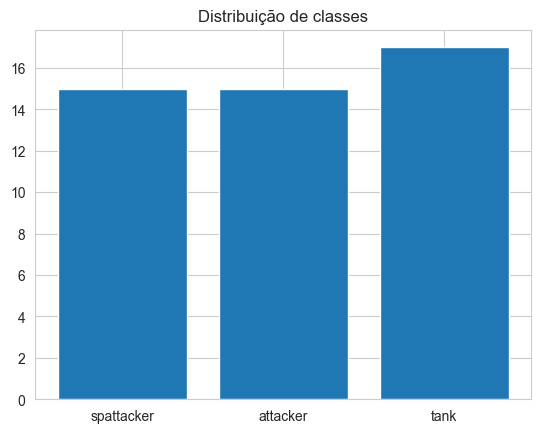

In [55]:
key_cnt = {}
for key in pokemon_by_role:
    key_cnt[key] = len(pokemon_by_role[key])
fig, ax = plt.subplots()
plt.bar(key_cnt.keys(), key_cnt.values())
ax.set_title('Distribuição de classes')


## Treinando modelos

In [56]:
status_columns = ["base_hp", "base_attack", "base_defense", "base_special_attack", "base_special_defense", "base_speed"]

train_data = pd.DataFrame(
    columns=status_columns + ["role"]
)

In [57]:
for key in pokemon_by_role.keys():
    pokemons = pokemon_by_role[key]

    for pokemon in pokemons:
        pokemon_data = pokedex_df_filtered[pokedex_df_filtered["name"] == pokemon]
        row = {
            "role": key
        }
        for status in status_columns:
            try:
                row[status] = pokemon_data[status].values[0]
            except e:
                print(f"Pokemon {pokemon} não foi encontrado")
                raise e
        row_series = pd.Series(row)
        train_data = pd.concat(
            [train_data, row_series.to_frame().T],
            ignore_index=True
        )

In [58]:
## TODO: balancear as classes de treinamento
X_train, X_test, y_train, y_test = train_test_split(train_data[status_columns], train_data["role"], random_state=2)

Testando os modelos SVM, LogisticRegression, RandomForestClassifier e DecisionTreeClassifier


In [59]:
models = [
    ("SVM", svm.SVC()),
    ("LogisticRegression", LogisticRegression(solver='newton-cholesky')),
    ("RandomForestClassifier", RandomForestClassifier(max_depth=4)),
    ("DecisionTreeClassifier", DecisionTreeClassifier(max_depth=4)),
]
scores = []
for (name, model) in models:
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print(f"{name} = {score}")
    scores.append(score)

bestModelIdx = scores.index(max(scores))
print(f"Melhor modelo: {models[bestModelIdx][0]}")

SVM = 0.8333333333333334
LogisticRegression = 0.9166666666666666
RandomForestClassifier = 0.75
DecisionTreeClassifier = 0.8333333333333334
Melhor modelo: LogisticRegression


In [60]:
model = models[bestModelIdx][1]

Testando combinações do LogisticRegression

In [61]:
param_grid = {
    'solver': ['newton-cg', 'newton-cg', 'newton-cg', 'newton-cholesky'],
    'tol': [.1, .01, .001, .0002],
}

pipeline = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, cv=5, scoring='accuracy', refit=True, n_jobs=10)
pipeline.fit(X_train, y_train)
print(pipeline.score(X_test, y_test))

1.0


In [62]:
model = pipeline

<Axes: >

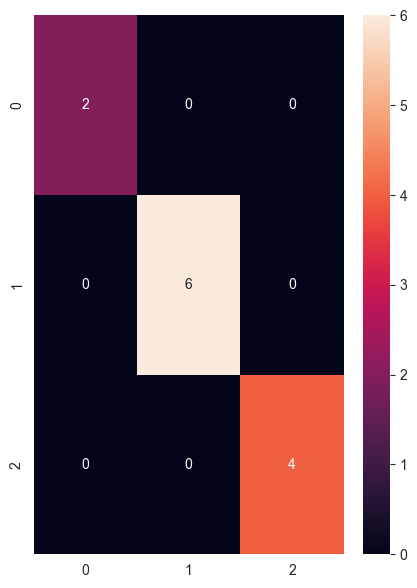

In [63]:
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 7))
sn.heatmap(conf_matrix, annot=True)

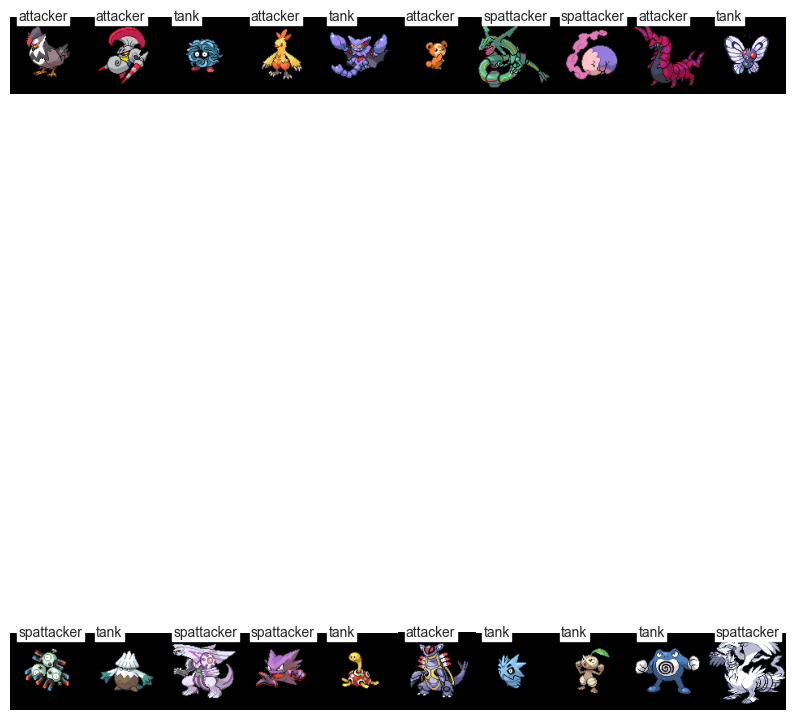

In [64]:
pokedex_df_sample = pokedex_df_filtered.sample(n=20)

pokedex_df_sample = pokedex_df_sample.assign(
    role=pipeline.predict(pokedex_df_sample[status_columns])
).reset_index()

f, axarr = plt.subplots(2, 10, figsize=(10, 10), gridspec_kw={'wspace': 0, 'hspace': 3})

for i in range(2):
    for j in range(10):
        image_url = pokedex_df_sample.loc[(i * 10) + j]["image_url"]
        image_file = imread(image_url)
        name = pokedex_df_sample.loc[(i * 10) + j]["name"]
        role = pokedex_df_sample.loc[(i * 10) + j]["role"]
        axarr[i][j].text(10, 5, role, bbox={'facecolor': 'white', 'pad': 1})

        axarr[i][j].imshow(image_file)
        axarr[i][j].axis('off')
        axarr[i][j].set_aspect('equal')

plt.show()

Veremos como ficaram os dados gerais com nosso treinamento:

Text(0, 0.5, 'Quantidade')

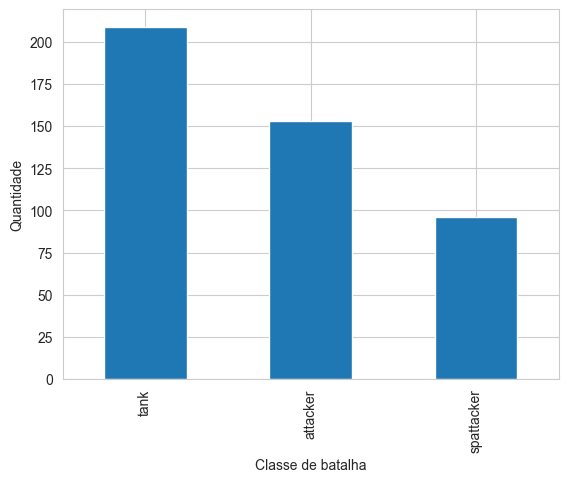

In [65]:
pokedex_df_filtered_with_predict = pokedex_df_filtered.assign(
    role=pipeline.predict(pokedex_df_filtered[status_columns])
)
pokedex_df_filtered_with_predict['role'].value_counts().plot(kind='bar')
plt.xlabel('Classe de batalha')
plt.ylabel('Quantidade')

<Axes: xlabel='type1'>

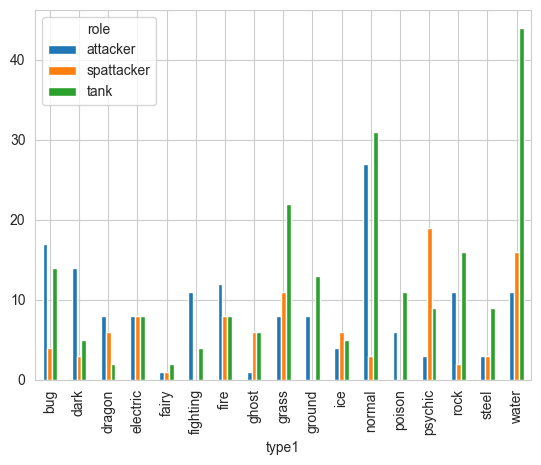

In [66]:
pd.crosstab(pokedex_df_filtered_with_predict['type1'],pokedex_df_filtered_with_predict['role']).plot.bar()

<Axes: xlabel='type2'>

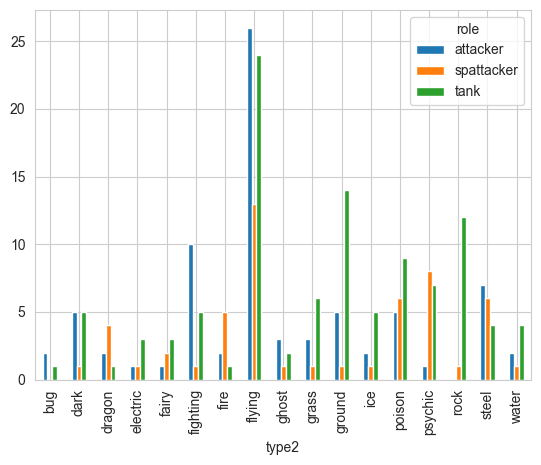

In [67]:
pd.crosstab(pokedex_df_filtered_with_predict['type2'],pokedex_df_filtered_with_predict['role']).plot.bar()

In [68]:
pokedex_df_filtered_with_predict.to_pickle('./pokedex_df_filtered_with_predict.pkl')

In [69]:
pokedex_df_filtered_with_predict

,color,is_legendary,is_mythical,name,shape,image_url,type,base_hp,base_attack,base_defense,base_special_attack,base_special_defense,base_speed,status_mean,type1,type2,role
1,green,False,False,ivysaur,quadruped,https://raw.githubusercontent.com/PokeAPI/spri...,"[grass, poison]",60,62,63,80,80,60,67.500000,grass,poison,tank
2,green,False,False,venusaur,quadruped,https://raw.githubusercontent.com/PokeAPI/spri...,"[grass, poison]",80,82,83,100,100,80,87.500000,grass,poison,spattacker
4,red,False,False,charmeleon,upright,https://raw.githubusercontent.com/PokeAPI/spri...,[fire],58,64,58,80,65,80,67.500000,fire,None,tank
5,red,False,False,charizard,upright,https://raw.githubusercontent.com/PokeAPI/spri...,"[fire, flying]",78,84,78,109,85,100,89.000000,fire,flying,spattacker
7,blue,False,False,wartortle,upright,https://raw.githubusercontent.com/PokeAPI/spri...,[water],59,63,80,65,80,58,67.500000,water,None,tank
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,green,True,False,virizion,quadruped,https://raw.githubusercontent.com/PokeAPI/spri...,"[grass, fighting]",91,90,72,90,129,108,96.666667,grass,fighting,spattacker
634,white,True,False,reshiram,wings,https://raw.githubusercontent.com/PokeAPI/spri...,"[dragon, fire]",100,120,100,150,120,90,113.333333,dragon,fire,spattacker
635,black,True,False,zekrom,upright,https://raw.githubusercontent.com/PokeAPI/spri...,"[dragon, electric]",100,150,120,120,100,90,113.333333,dragon,electric,spattacker
636,gray,True,False,kyurem,upright,https://raw.githubusercontent.com/PokeAPI/spri...,"[dragon, ice]",125,130,90,130,90,95,110.000000,dragon,ice,spattacker
